In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
import warnings
from scipy import stats
import datetime as dt

In [2]:
volc = np.genfromtxt('nature14565-s6_sigl2015.csv', delimiter=",", dtype=float)
data_mann_2009 = np.genfromtxt('nino3all_mann_2009_v1.txt', delimiter=",", dtype=float) # nino3 reconstruction


In [3]:
# Singular Spectral Analysis as in Sinha et al 2015
def X_to_TS(X_i):
    """Averages the anti-diagonals of the given elementary matrix, X_i, and returns a time series."""
    # Reverse the column ordering of X_i
    X_rev = X_i[::-1]
    # Full credit to Mark Tolonen at https://stackoverflow.com/a/6313414 for this one:
    return np.array([X_rev.diagonal(i).mean() for i in range(-X_i.shape[0]+1, X_i.shape[1])])

def ssa(F):
    N = F.shape[0]
    L = 30# The window length.
    K = N - L + 1 # The number of columns in the trajectory matrix.
    # Create the trajectory matrix by pulling the relevant subseries of F, and stacking them as columns.
    X = np.column_stack([F[i:i+L] for i in range(0,K)])
    # Note: the i+L above gives us up to i+L-1, as numpy array upper bounds are exclusive. 
    d = np.linalg.matrix_rank(X) # The intrinsic dimensionality of the trajectory space.
    U, Sigma, V = np.linalg.svd(X)
    V = V.T # Note: the SVD routine returns V^T, not V, so I'll tranpose it back here. This may seem pointless, 
    X_elem = np.array( [Sigma[i] * np.outer(U[:,i], V[:,i]) for i in range(0,d)] )
    n = min(12,d) # In case of noiseless time series with d < 12.
    # Convert elementary matrices straight to a time series - no need to construct any Hankel matrices.
    F_i = np.zeros((n,N))
    for i in range(n):
        F_i[i,:] = X_to_TS(X_elem[i])
    return F_i


Proxies used in Mann et al 2009 Nino3 reconstructions
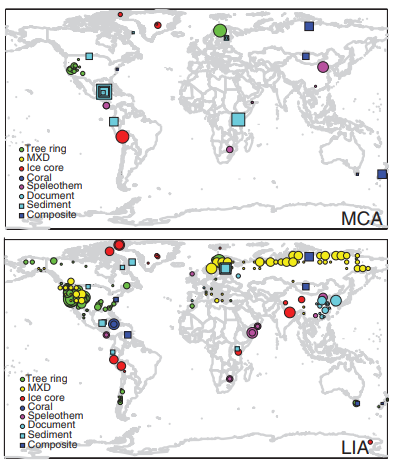

In [4]:
yy_mann = data_mann_2009[:,0]
nino3_mann = data_mann_2009[:,1]
nino3_mann_ssa = ssa(nino3_mann)

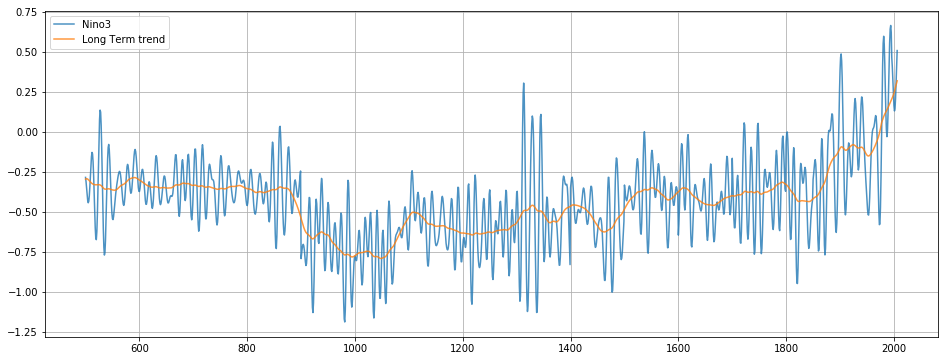

In [5]:
# Trend from Singular Spectral Analysis
plt.figure(figsize=(16,6))
plt.plot(yy_mann, nino3_mann, label='Nino3', alpha=0.8)
plt.plot(yy_mann, nino3_mann_ssa[0], label='Long Term trend', alpha=0.8)
plt.legend()
plt.grid()

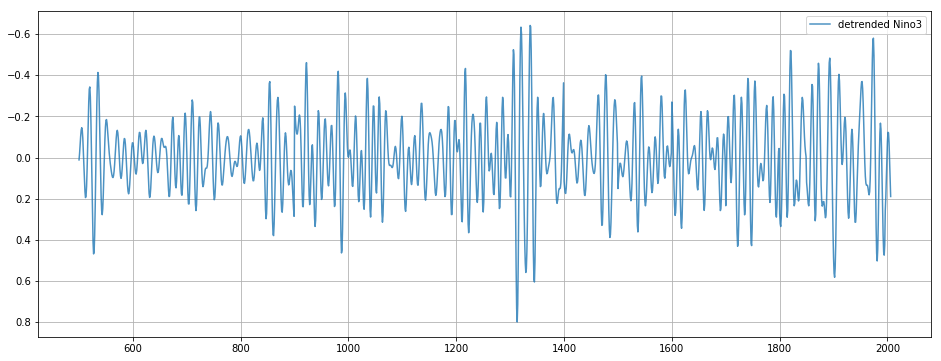

In [6]:
plt.figure(figsize=(16,6))
plt.plot(yy_mann, nino3_mann-nino3_mann_ssa[0], label='detrended Nino3', alpha=0.8)
plt.legend()
plt.gca().invert_yaxis()
plt.grid()

In [7]:
nino3_mann_detrend = nino3_mann-nino3_mann_ssa[0]

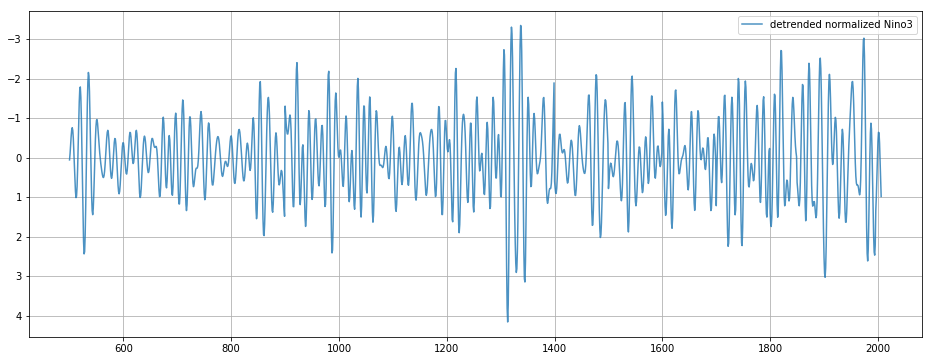

In [8]:
nino3_mann_detrend_norm = (nino3_mann_detrend - np.mean(nino3_mann_detrend))/(np.std(nino3_mann_detrend))
plt.figure(figsize=(16,6))
plt.plot(yy_mann, nino3_mann_detrend_norm, label='detrended normalized Nino3', alpha=0.8)
plt.legend()
plt.gca().invert_yaxis()
plt.grid()

In [9]:
yy_ann = yy_mann
event_en_mann = np.zeros((yy_ann.shape[0]))
event_yy_volc_all = np.zeros((yy_ann.shape[0]))
event_yy_volc_strong = np.zeros((yy_ann.shape[0]))
event_yy_volc_all_trop = np.zeros((yy_ann.shape[0]))
event_yy_volc_all_nh = np.zeros((yy_ann.shape[0]))
event_yy_volc_all_sh = np.zeros((yy_ann.shape[0]))
event_yy_volc_strong_trop = np.zeros((yy_ann.shape[0]))
event_yy_volc_strong_nh = np.zeros((yy_ann.shape[0]))
event_yy_volc_strong_sh = np.zeros((yy_ann.shape[0]))

In [10]:
event_en_mann[nino3_mann_detrend_norm>1.0] = 1.0

for i in range(yy_ann.shape[0]):
    #print(event_yy_kobb[i])
    idx = np.asarray(np.where(volc[:,0] == yy_ann[i]))
    #print(idx.size)
    if idx.size==0:
        continue
    event_yy_volc_all[i] = 1.0
    if np.abs(volc[idx[0,0],2])>=5.0:
        event_yy_volc_strong[i] = 1.0
    
    if volc[idx[0,0],1] == 1.0:
        event_yy_volc_all_trop[i] = 1.0
    if volc[idx[0,0],1] == 2.0:
        event_yy_volc_all_nh[i] = 1.0
    if volc[idx[0,0],1] == 3.0:
        event_yy_volc_all_sh[i] = 1.0
        
    if (volc[idx[0,0],1] == 1.0) & (np.abs(volc[idx[0,0],2])>=3.7):
        event_yy_volc_strong_trop[i] = 1.0
    if (volc[idx[0,0],1] == 2.0) & (np.abs(volc[idx[0,0],2])>=3.7):
        event_yy_volc_strong_nh[i] = 1.0
    if (volc[idx[0,0],1] == 3.0) & (np.abs(volc[idx[0,0],2])>=3.7):
        event_yy_volc_strong_sh[i] = 1.0

In [11]:
np.savetxt('en_mann_2009.txt', event_en_mann, delimiter=",")
np.savetxt('all_volc_mann_2009.txt', event_yy_volc_all, delimiter=",")
np.savetxt('strong_volc_mann_2009.txt', event_yy_volc_strong, delimiter=",")
np.savetxt('all_tropical_mann_2009.txt', event_yy_volc_all_trop, delimiter=",")
np.savetxt('strong_tropical_mann_2009.txt', event_yy_volc_strong_trop, delimiter=",")
np.savetxt('all_nh_mann_2009.txt', event_yy_volc_all_nh, delimiter=",")
np.savetxt('strong_nh_mann_2009.txt', event_yy_volc_strong_nh, delimiter=",")
np.savetxt('all_sh_mann_2009.txt', event_yy_volc_all_sh, delimiter=",")
np.savetxt('strong_sh_mann_2009.txt', event_yy_volc_strong_sh, delimiter=",")

In [12]:
print(np.sum(event_yy_volc_all))
print(np.sum(event_yy_volc_strong))
print(np.sum(event_yy_volc_all_trop))
print(np.sum(event_yy_volc_strong_trop))
print(np.sum(event_yy_volc_all_nh))
print(np.sum(event_yy_volc_strong_nh))
print(np.sum(event_yy_volc_all_sh))
print(np.sum(event_yy_volc_strong_sh))

182.0
32.0
51.0
33.0
94.0
8.0
37.0
0.0


In [13]:
# Bootstrap
N = 1000
win = 5
count_elnino_all_volc = np.zeros((N, win))
count_elnino_strong_volc  = np.zeros((N, win))
count_elnino_all_trop  = np.zeros((N, win))
count_elnino_strong_trop  = np.zeros((N, win))
count_elnino_all_nh  = np.zeros((N, win))
count_elnino_strong_nh  = np.zeros((N, win))
count_elnino_all_sh  = np.zeros((N, win))

In [14]:
idx_all = np.asarray(np.where(event_yy_volc_all == 1.0))
idx_strong = np.asarray(np.where(event_yy_volc_strong == 1.0))
idx_all_trop = np.asarray(np.where(event_yy_volc_all_trop == 1.0))
idx_strong_trop = np.asarray(np.where(event_yy_volc_strong_trop == 1.0))
idx_all_nh = np.asarray(np.where(event_yy_volc_all_nh == 1.0))
idx_strong_nh = np.asarray(np.where(event_yy_volc_strong_nh == 1.0))
idx_all_sh = np.asarray(np.where(event_yy_volc_all_sh == 1.0))

In [15]:
print(idx_all[0])

[   1   11   21   28   36   40   47   71   74   81   89   95  107  126
  129  132  137  141  157  171  182  188  194  198  213  217  225  232
  245  249  250  256  264  277  282  300  317  319  322  327  335  337
  341  353  359  369  376  379  380  400  404  408  416  429  439  446
  453  458  460  470  476  482  490  498  503  511  517  520  528  539
  557  564  567  592  608  615  618  627  637  671  680  682  691  700
  710  722  730  736  758  762  769  776  786  806  829  836  841  845
  878  881  889  908  914  916  941  948  953  958  963  970  977  978
  980 1002 1005 1012 1028 1037 1041 1054 1067 1076 1085 1090 1095 1101
 1119 1121 1137 1141 1146 1154 1162 1167 1173 1193 1195 1208 1219 1220
 1221 1225 1229 1239 1256 1262 1266 1270 1283 1286 1296 1297 1309 1315
 1321 1323 1332 1336 1346 1353 1356 1362 1373 1375 1384 1387 1390 1403
 1408 1412 1419 1425 1426 1431 1443 1447 1457 1464 1468 1479 1482 1491]


In [16]:
niter = 0
while niter<N:
    rand_year_all = random.sample(list(idx_all[0]), 1)
    if (rand_year_all[0]<nino3_mann_detrend_norm.shape[0]-win):
        count_elnino_all_volc[niter,:] = nino3_mann_detrend_norm[rand_year_all[0]:rand_year_all[0]+win]
    
    rand_year_strong = random.sample(list(idx_strong[0]), 1)
    if (rand_year_strong[0]<nino3_mann_detrend_norm.shape[0]-win):
        count_elnino_strong_volc[niter,:] = nino3_mann_detrend_norm[rand_year_strong[0]:rand_year_strong[0]+win]
    
    rand_year_all_trop = random.sample(list(idx_all_trop[0]), 1)
    if (rand_year_all_trop[0]<nino3_mann_detrend_norm.shape[0]-win):
        count_elnino_all_trop[niter,:] = nino3_mann_detrend_norm[rand_year_all_trop[0]:rand_year_all_trop[0]+win]

    rand_year_strong_trop = random.sample(list(idx_strong_trop[0]), 1)
    if (rand_year_strong_trop[0]<nino3_mann_detrend_norm.shape[0]-win):
        count_elnino_strong_trop[niter,:] = nino3_mann_detrend_norm[rand_year_strong_trop[0]:rand_year_strong_trop[0]+win]

    rand_year_all_nh = random.sample(list(idx_all_nh[0]), 1)
    if (rand_year_all_nh[0]<nino3_mann_detrend_norm.shape[0]-win):
        count_elnino_all_nh[niter,:] = nino3_mann_detrend_norm[rand_year_all_nh[0]:rand_year_all_nh[0]+win]

    rand_year_strong_nh = random.sample(list(idx_strong_nh[0]), 1)
    if (rand_year_strong_nh[0]<nino3_mann_detrend_norm.shape[0]-win):
        count_elnino_strong_nh[niter,:] = nino3_mann_detrend_norm[rand_year_strong_nh[0]:rand_year_strong_nh[0]+win]

    rand_year_all_sh = random.sample(list(idx_all_sh[0]), 1)
    if (rand_year_all_sh[0]<nino3_mann_detrend_norm.shape[0]-win):
        count_elnino_all_sh[niter,:] = nino3_mann_detrend_norm[rand_year_all_sh[0]:rand_year_all_sh[0]+win]
    
    #print(s[rand_year_all[0]:rand_year_all[0]+win])
    #print(rand_year_all[0])
    niter = niter + 1 

/iitm2/cccr-res/msingh/anaconda3/envs/py35/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


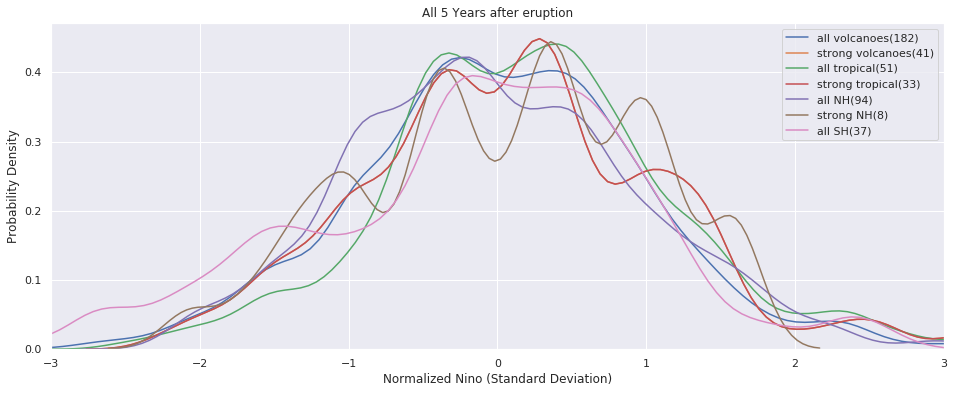

In [17]:
import seaborn as sns; sns.set(color_codes=True)
plt.figure(figsize=(16,6))
sns.kdeplot(count_elnino_all_volc.flatten(), label='all volcanoes(182)')
sns.kdeplot(count_elnino_strong_volc.flatten(), label='strong volcanoes(41)')
sns.kdeplot(count_elnino_all_trop.flatten(), label='all tropical(51)')
sns.kdeplot(count_elnino_strong_volc.flatten(), label='strong tropical(33)')
sns.kdeplot(count_elnino_all_nh.flatten(), label='all NH(94)')
sns.kdeplot(count_elnino_strong_nh.flatten(), label='strong NH(8)')
sns.kdeplot(count_elnino_all_sh.flatten(), label='all SH(37)')
plt.title('All 5 Years after eruption')
plt.ylabel('Probability Density')
plt.xlabel('Normalized Nino (Standard Deviation)')
plt.xlim([-3,3])
plt.legend()

/iitm2/cccr-res/msingh/anaconda3/envs/py35/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


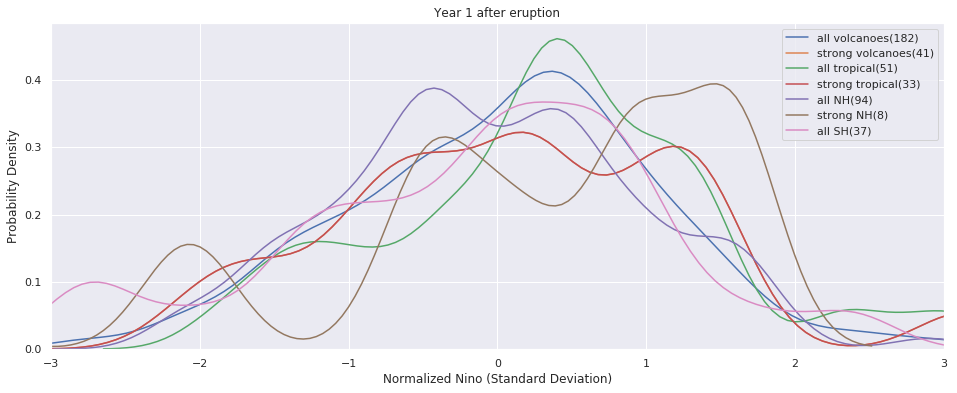

In [18]:
import seaborn as sns; sns.set(color_codes=True)
plt.figure(figsize=(16,6))
sns.kdeplot(count_elnino_all_volc[:,0], label='all volcanoes(182)')
sns.kdeplot(count_elnino_strong_volc[:,0], label='strong volcanoes(41)')
sns.kdeplot(count_elnino_all_trop[:,0], label='all tropical(51)')
sns.kdeplot(count_elnino_strong_volc[:,0], label='strong tropical(33)')
sns.kdeplot(count_elnino_all_nh[:,0], label='all NH(94)')
sns.kdeplot(count_elnino_strong_nh[:,0], label='strong NH(8)')
sns.kdeplot(count_elnino_all_sh[:,0], label='all SH(37)')
plt.title('Year 1 after eruption')
plt.ylabel('Probability Density')
plt.xlabel('Normalized Nino (Standard Deviation)')
plt.xlim([-3,3])
plt.legend()

/iitm2/cccr-res/msingh/anaconda3/envs/py35/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


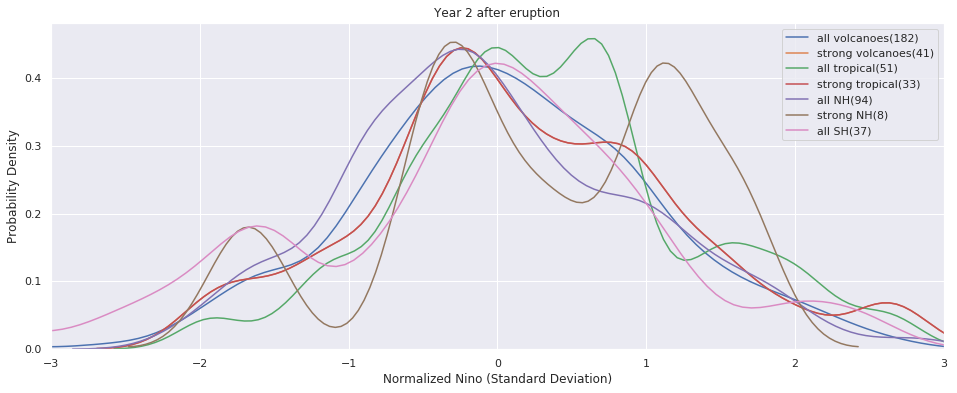

In [19]:
import seaborn as sns; sns.set(color_codes=True)
plt.figure(figsize=(16,6))
sns.kdeplot(count_elnino_all_volc[:,1], label='all volcanoes(182)')
sns.kdeplot(count_elnino_strong_volc[:,1], label='strong volcanoes(41)')
sns.kdeplot(count_elnino_all_trop[:,1], label='all tropical(51)')
sns.kdeplot(count_elnino_strong_volc[:,1], label='strong tropical(33)')
sns.kdeplot(count_elnino_all_nh[:,1], label='all NH(94)')
sns.kdeplot(count_elnino_strong_nh[:,1], label='strong NH(8)')
sns.kdeplot(count_elnino_all_sh[:,1], label='all SH(37)')
plt.title('Year 2 after eruption')
plt.ylabel('Probability Density')
plt.xlabel('Normalized Nino (Standard Deviation)')
plt.xlim([-3,3])
plt.legend()

/iitm2/cccr-res/msingh/anaconda3/envs/py35/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


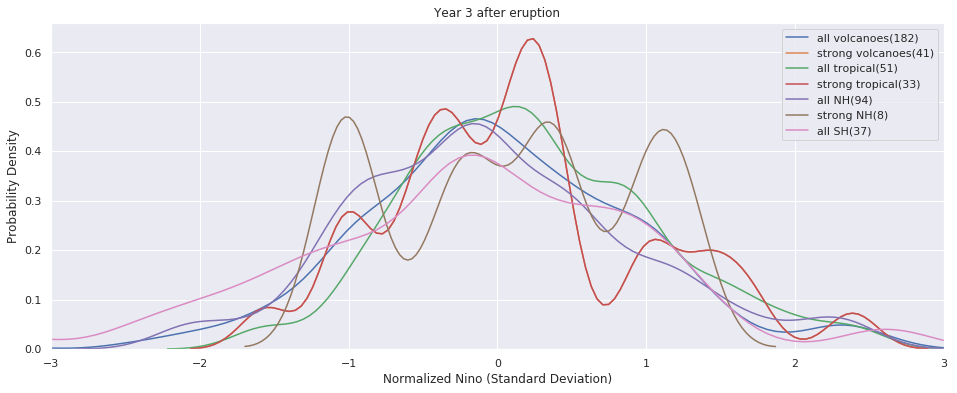

In [20]:
import seaborn as sns; sns.set(color_codes=True)
plt.figure(figsize=(16,6))
sns.kdeplot(count_elnino_all_volc[:,2], label='all volcanoes(182)')
sns.kdeplot(count_elnino_strong_volc[:,2], label='strong volcanoes(41)')
sns.kdeplot(count_elnino_all_trop[:,2], label='all tropical(51)')
sns.kdeplot(count_elnino_strong_volc[:,2], label='strong tropical(33)')
sns.kdeplot(count_elnino_all_nh[:,2], label='all NH(94)')
sns.kdeplot(count_elnino_strong_nh[:,2], label='strong NH(8)')
sns.kdeplot(count_elnino_all_sh[:,2], label='all SH(37)')
plt.title('Year 3 after eruption')
plt.ylabel('Probability Density')
plt.xlabel('Normalized Nino (Standard Deviation)')
plt.xlim([-3,3])
plt.legend()

/iitm2/cccr-res/msingh/anaconda3/envs/py35/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


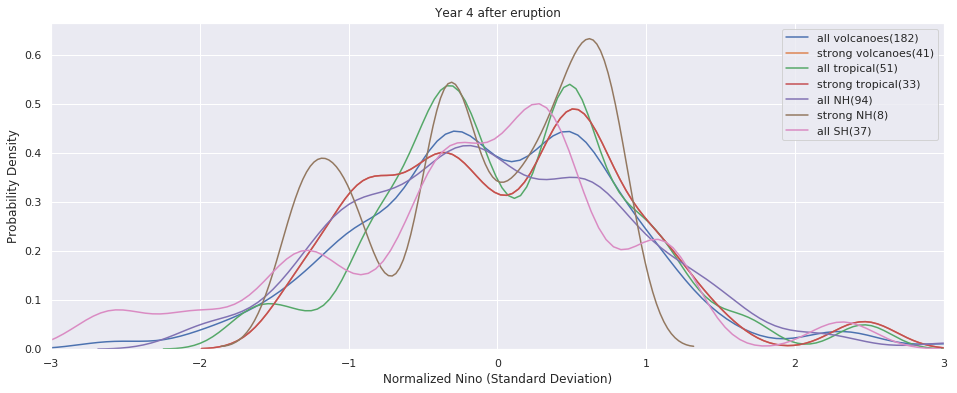

In [21]:
import seaborn as sns; sns.set(color_codes=True)
plt.figure(figsize=(16,6))
sns.kdeplot(count_elnino_all_volc[:,3], label='all volcanoes(182)')
sns.kdeplot(count_elnino_strong_volc[:,3], label='strong volcanoes(41)')
sns.kdeplot(count_elnino_all_trop[:,3], label='all tropical(51)')
sns.kdeplot(count_elnino_strong_volc[:,3], label='strong tropical(33)')
sns.kdeplot(count_elnino_all_nh[:,3], label='all NH(94)')
sns.kdeplot(count_elnino_strong_nh[:,3], label='strong NH(8)')
sns.kdeplot(count_elnino_all_sh[:,3], label='all SH(37)')
plt.title('Year 4 after eruption')
plt.ylabel('Probability Density')
plt.xlabel('Normalized Nino (Standard Deviation)')
plt.xlim([-3,3])
plt.legend()

/iitm2/cccr-res/msingh/anaconda3/envs/py35/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


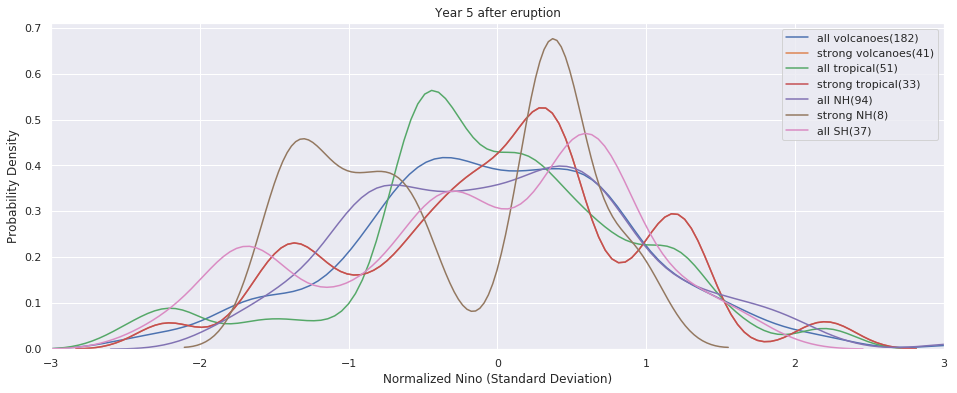

In [22]:
import seaborn as sns; sns.set(color_codes=True)
plt.figure(figsize=(16,6))
sns.kdeplot(count_elnino_all_volc[:,4], label='all volcanoes(182)')
sns.kdeplot(count_elnino_strong_volc[:,4], label='strong volcanoes(41)')
sns.kdeplot(count_elnino_all_trop[:,4], label='all tropical(51)')
sns.kdeplot(count_elnino_strong_volc[:,4], label='strong tropical(33)')
sns.kdeplot(count_elnino_all_nh[:,4], label='all NH(94)')
sns.kdeplot(count_elnino_strong_nh[:,4], label='strong NH(8)')
sns.kdeplot(count_elnino_all_sh[:,4], label='all SH(37)')
plt.title('Year 5 after eruption')
plt.ylabel('Probability Density')
plt.xlabel('Normalized Nino (Standard Deviation)')
plt.xlim([-3,3])
plt.legend()

In [23]:
nino3_mann_2009_anom_yy = np.zeros((nino3_mann_detrend_norm.shape[0],3))
nino3_mann_2009_anom_yy[:,0] = yy_mann[:]
nino3_mann_2009_anom_yy[:,1] = event_yy_volc_strong[:]
nino3_mann_2009_anom_yy[:,2] = -nino3_mann_detrend_norm[:]
np.savetxt('nino3_mann_2009_anom_yy.txt', nino3_mann_2009_anom_yy, delimiter=",")